In [16]:
#Import shit
import pandas
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [17]:
#google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
num_pokemon = 6
pics_per    = 6
test_pics   = 2

In [19]:
def adjust_intensities(data):
  return (data/255)-0.5


#lisa's method
def create_set(keys, images, num_pics):
  N = num_pokemon
  c = 0
  pokemon = []

  for i in range(N):
    pics = []
    for j in range(num_pics):
      pics.append(images[keys[c]])
      c+=1
    pokemon.append(np.stack(pics))
  return adjust_intensities(np.stack(pokemon))

def get_set(path, num_pics):
  images = {}
  for file in glob.glob(path):
    filename         = file.split("/")[-1] #get the name of the .jpg file
    img              = plt.imread(file)    #read the image as numpy array
    #print(img.shape)
    images[filename] = img[:,:,:]          #remove alpha channel

  keys = sorted(images.keys()) # keys is the list of file names in the images dictionary
  return create_set(keys, images, num_pics)


path_to_data = "/content/gdrive/My Drive/Pokemon_NN/"
train_data   = get_set(path_to_data + "train/*.jpg", pics_per)
train_data   = torch.from_numpy(train_data)

test_data    = get_set(path_to_data + "test/*.jpg", test_pics)
test_data    = torch.from_numpy(test_data)

f = open(path_to_data + "poke_list.txt")
list_classes = f.read().split()

In [ ]:

#just making sure we got the data properly
#this loop should print the first image from each pokemon
for i in range(num_pokemon):
  plt.figure()
  plt.imshow(train_data[i,0,:,:,:])

In [31]:
class CNN(nn.Module):
  def __init__(self, n=4):
    super(CNN, self).__init__()
    self.n     = n
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=5,padding=3)
    self.bn1   = nn.BatchNorm2d(n)
    self.conv2 = nn.Conv2d(in_channels=n, out_channels=n*2, kernel_size=5, padding=3)
    self.bn2   = nn.BatchNorm2d(n*2)
    self.conv3 = nn.Conv2d(in_channels=n*2, out_channels=n*4, kernel_size=3, stride=1)
    self.bn3   = nn.BatchNorm2d(n*4)
    self.conv4 = nn.Conv2d(in_channels=n*4, out_channels=n*8, kernel_size=3, padding=1)
    self.bn4   = nn.BatchNorm2d(n*8)
    self.fc1   = nn.Linear(n*8*13*13, 100)
    self.fc2   = nn.Linear(100, num_pokemon)
    self.pool  = nn.MaxPool2d(2,2)
    self.activation = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.transpose(1, 3).transpose(2, 3)
    x = self.bn1(torch.relu(self.conv1(x)))
    x = self.pool(x)
    x = self.bn2(torch.relu(self.conv2(x)))
    x = self.pool(x)
    x = self.bn3(torch.relu(self.conv3(x)))
    x = self.pool(x)
    x = self.bn4(torch.relu(self.conv4(x)))
    x = self.pool(x)
    x = x.view(-1, self.n*8*13*13)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.activation(x)
    return x

brain = CNN()

In [22]:
def create_labels(samples):
  ts = torch.zeros(num_pokemon * samples, samples)
  for i in range(num_pokemon * samples):
    ts[i, i//num_pokemon] = 1.0
  labels = torch.argmax(ts, dim=1)
  return labels

def create_inputs(data, samples):
  xs = torch.zeros(num_pokemon * samples, 224, 224, 3)
  c  = 0
  for i in range(num_pokemon):
    for k in range(samples):
      xs[c] = data[i, k]
      c+=1
  return xs

def get_accuracy(ys, labels, batch_size):
  predictions = torch.argmax(ys, dim=1)
  correct = 0
  for i in range(batch_size):
    if predictions[i] == labels[i]:
      correct += 1

  return (correct/batch_size)*100

In [32]:
def learn(model, training_data, test_data, weight_decay=0.0, learning_rate=0.001, optimizer="sgd",
          momentum=0.9, num_epochs=250):
  criterion = nn.CrossEntropyLoss()
  # optimizer
  assert optimizer in ("sgd", "adam")
  if optimizer == "sgd":
      optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
  else:
      optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

  #tagets
  labels      = create_labels(pics_per)
  test_labels = create_labels(test_pics)
  print(labels.shape)
  print(test_labels.shape)

  #inputs
  xs      = create_inputs(training_data, pics_per)
  test_xs = create_inputs(test_data, test_pics)
  
  for epoch in range(num_epochs):
    model.train()
    ys = model(xs)

    loss = criterion(ys, labels)
    loss.backward()

    optimizer.step()

    acc = get_accuracy(ys, labels, num_pokemon * pics_per)
    test_acc = get_accuracy(model(test_xs), test_labels, num_pokemon * test_pics)
    print("Epoch: {0}. Training Accuracy: {1}%. Test Accuracy: {2}".format(epoch, acc, test_acc))
    if acc >= 80 and test_acc >= 50:
      break;
    

learn(brain, train_data, test_data)

torch.Size([36])
torch.Size([12])
Epoch: 0. Training Accuracy: 16.666666666666664%. Test Accuracy: 0.0
Epoch: 1. Training Accuracy: 16.666666666666664%. Test Accuracy: 8.333333333333332
Epoch: 2. Training Accuracy: 16.666666666666664%. Test Accuracy: 16.666666666666664
Epoch: 3. Training Accuracy: 27.77777777777778%. Test Accuracy: 25.0
Epoch: 4. Training Accuracy: 41.66666666666667%. Test Accuracy: 25.0
Epoch: 5. Training Accuracy: 58.333333333333336%. Test Accuracy: 41.66666666666667
Epoch: 6. Training Accuracy: 66.66666666666666%. Test Accuracy: 33.33333333333333
Epoch: 7. Training Accuracy: 72.22222222222221%. Test Accuracy: 41.66666666666667
Epoch: 8. Training Accuracy: 75.0%. Test Accuracy: 50.0
Epoch: 9. Training Accuracy: 77.77777777777779%. Test Accuracy: 58.333333333333336
Epoch: 10. Training Accuracy: 80.55555555555556%. Test Accuracy: 58.333333333333336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


This is a picture of eevee


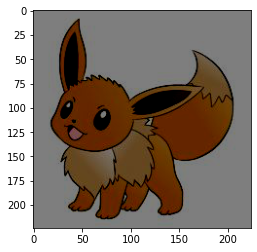